# Import

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os, yaml
sys.path.append('../lib')
sys.path.append('../analysis')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from lumi_utilities import getLumiByTrigger
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from array import array
from categoriesDef import categories

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Events
from DataFormats.FWLite import Handle

In [3]:
from prettytable import PrettyTable

In [4]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [5]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [6]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

In [7]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Get MC

In [8]:
cat = categories['low']

In [9]:
#They all have to be produced with the same pileup
MCsample = {
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
# 'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
# 'Hc' : DSetLoader('B0_DmstHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
# 'DstPi0' : DSetLoader('B0_DmstPi0MuNu_PUc0'),
# 'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
# 'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
# 'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
df = {}
for n, s in MCsample.iteritems():
    df[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_trkCtrl_corr.root'.format(cat.name)))

In [10]:
for dn in ['mu', 'DstPip']:
    print dn
    d = df[dn]
    sel = d['N_goodAddTks'] == 1
    print 'Tot: {:.1f} %'.format(100*np.sum(d['MC_tkFlag_0'][sel] > 0)/float(np.sum(sel)))
    
    selp = np.logical_and(sel, d['tkCharge_0'] > 0)
    print 'Plus: {:.1f} %'.format(100*np.sum(d['MC_tkFlag_0'][selp] > 0)/float(np.sum(selp)))
    selm = np.logical_and(sel, d['tkCharge_0'] < 0)
    print 'Minus: {:.1f} %'.format(100*np.sum(d['MC_tkFlag_0'][selm] > 0)/float(np.sum(selm)))
    
    
    print '\n'+30*'-'+ '\n'

mu
Tot: 11.0 %
Plus: 11.7 %
Minus: 10.1 %

------------------------------

DstPip
Tot: 84.7 %
Plus: 86.8 %
Minus: 13.6 %

------------------------------



### Some MC plots

In [11]:
d = df['DstPip']

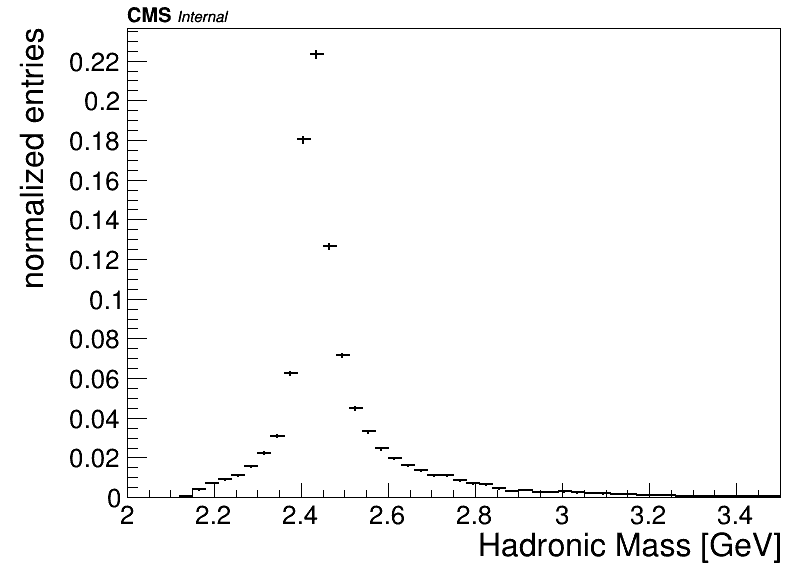

In [12]:
sel = np.logical_and(d['N_goodAddTks'] == 1, d['tkCharge_0'] > 0)
h = create_TH1D(d['tkMassHad_0'][sel], binning=[50, 2, 3.5], axis_title=['Hadronic Mass [GeV]', 'normalized entries'], scale_histo='norm')
c = drawOnCMSCanvas(CMS_lumi, [h])

In [13]:
np.sum(np.logical_and(d['MC_tkFlag_0'] == 1, sel))/float(np.sum(sel))

0.8675069265386525

In [14]:
selDstPi = np.logical_and(df['DstPip']['N_goodAddTks'] == 1, df['DstPip']['tkCharge_0'] > 0)
selDstPi = np.logical_and(df['DstPip']['MC_tkFlag_0'] == 1, selDstPi)
selMu = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['tkCharge_0'] > 0)
selMu = np.logical_and(df['mu']['MC_tkFlag_0'] == 1, selMu)

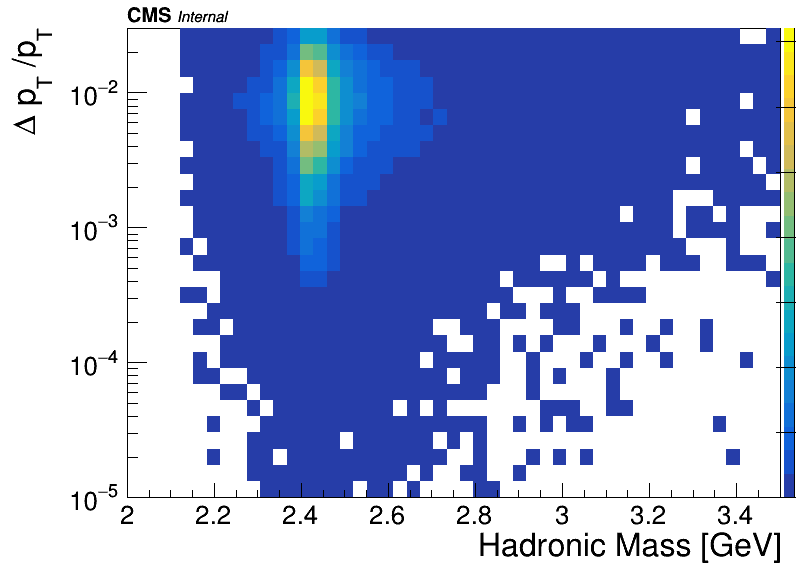

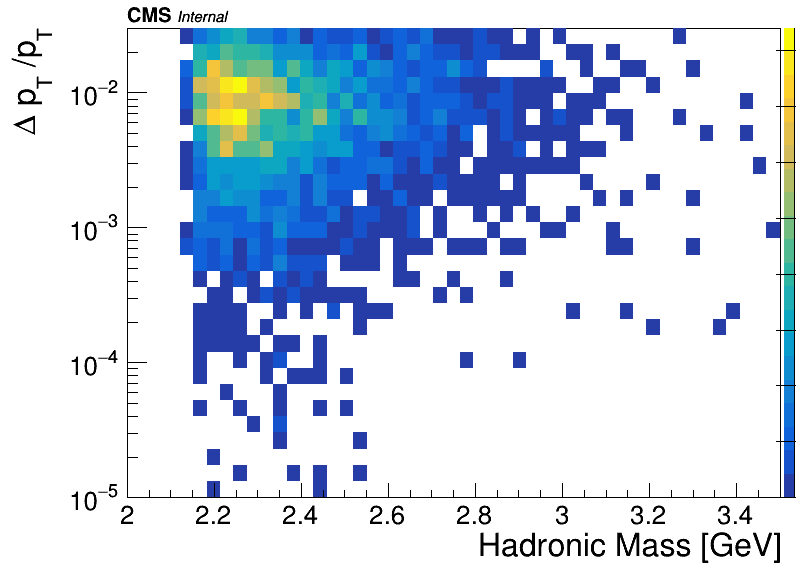

In [15]:
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], df['DstPip']['MC_tk_dpt_0'][selDstPi])), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.03), 30)], 
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} /p_{T}', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], df['mu']['MC_tk_dpt_0'][selMu])), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.03), 30)], 
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} /p_{T}', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

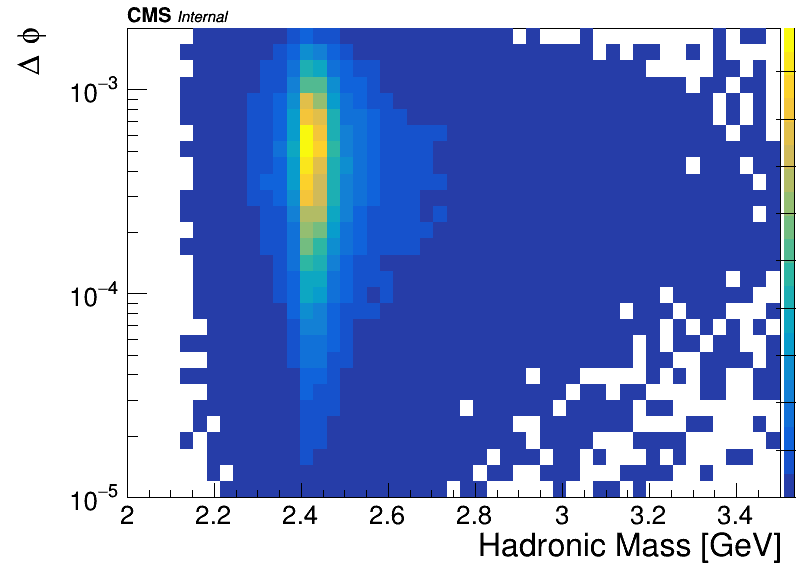

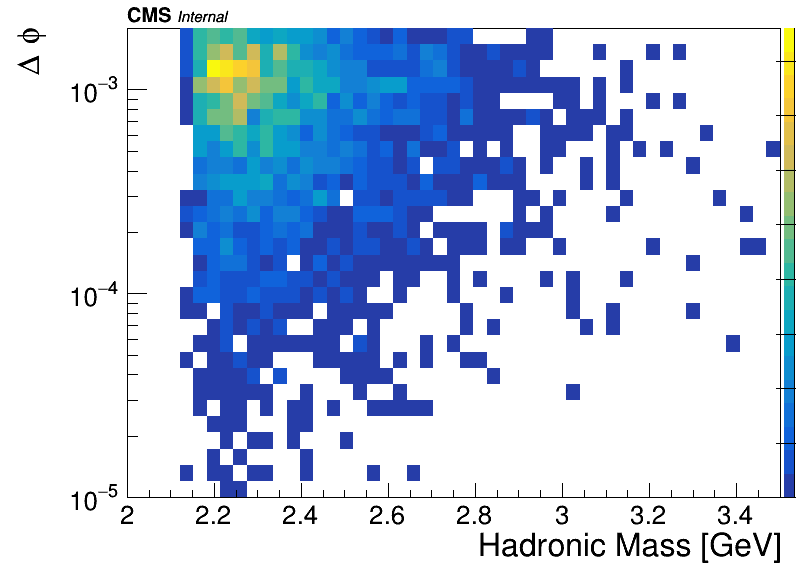

In [16]:
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], df['DstPip']['MC_tk_dphi_0'][selDstPi])), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #phi', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], df['mu']['MC_tk_dphi_0'][selMu])), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #phi', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

In [17]:
print np.sum(np.logical_and(df['DstPip']['MC_tk_dphi_0'] < 0.001, selDstPi))/float(np.sum(selDstPi))
print np.sum(np.logical_and(df['mu']['MC_tk_dphi_0'] < 0.001, selMu))/float(np.sum(selMu))

0.9019347216068527
0.638369598528961


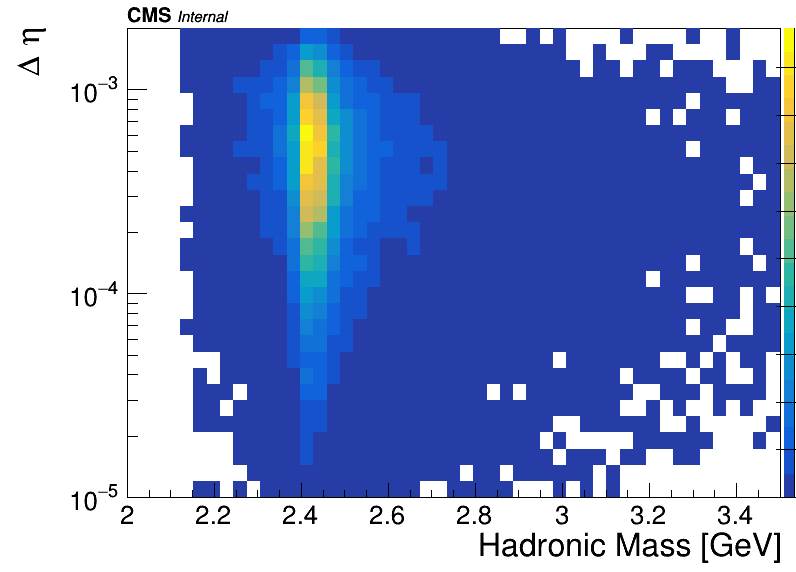

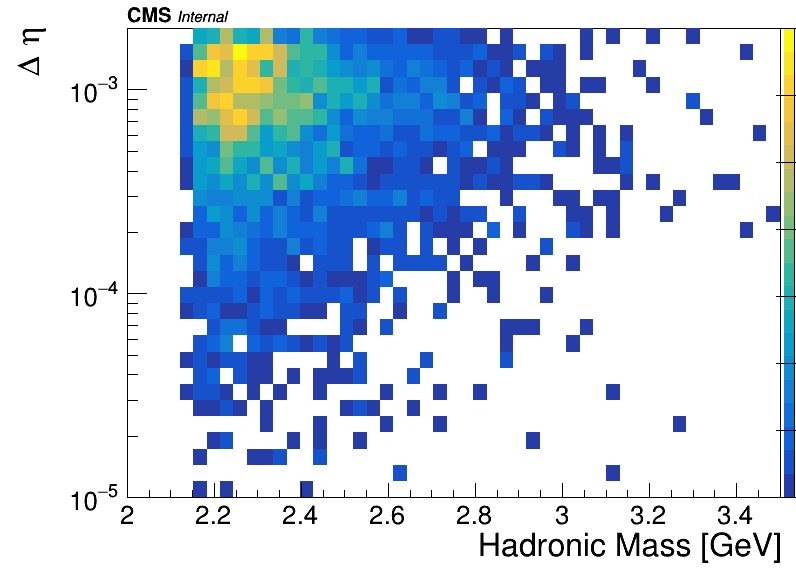

In [18]:
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], df['DstPip']['MC_tk_deta_0'][selDstPi])), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #eta', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], df['mu']['MC_tk_deta_0'][selMu])), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #eta', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

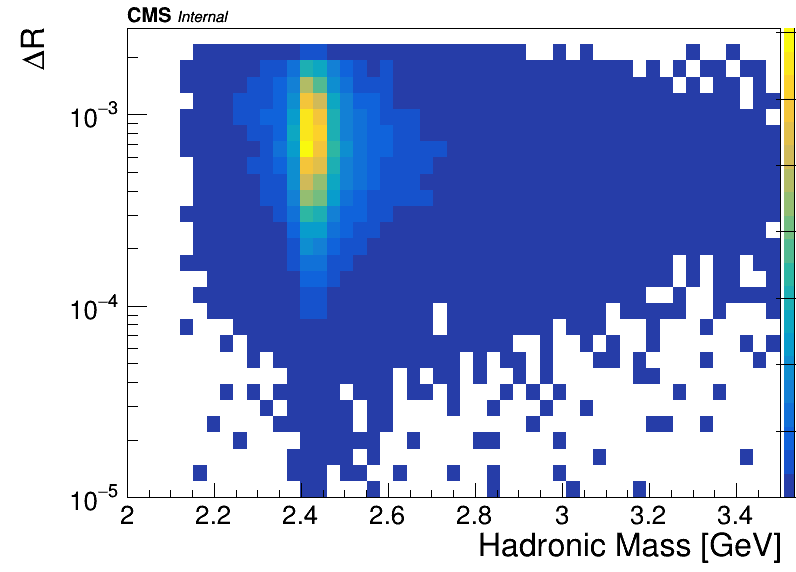

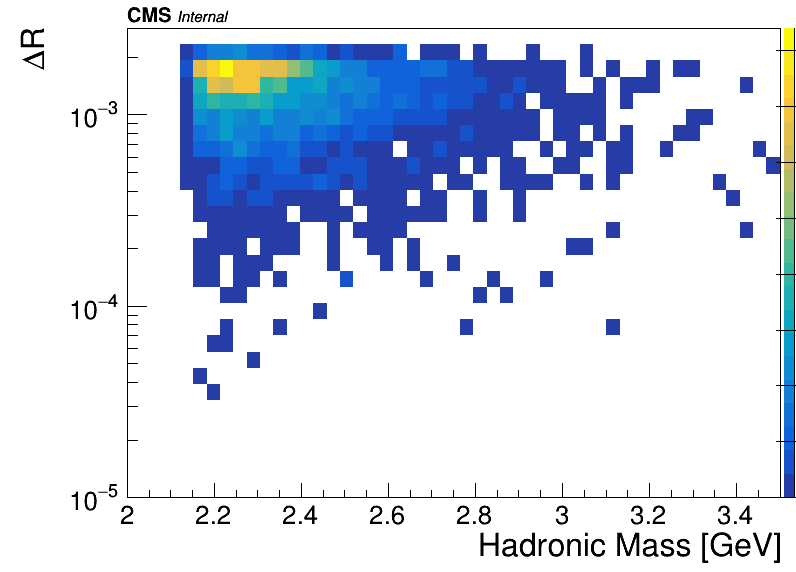

In [19]:
dRDstPi = np.hypot(df['DstPip']['MC_tk_deta_0'][selDstPi], df['DstPip']['MC_tk_dphi_0'][selDstPi])
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002*np.sqrt(2)), 30)],
                axis_title=['Hadronic Mass [GeV]', '#DeltaR', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

dRMu = np.hypot(df['mu']['MC_tk_deta_0'][selMu], df['mu']['MC_tk_dphi_0'][selMu])
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002*np.sqrt(2)), 30)],
                axis_title=['Hadronic Mass [GeV]', '#DeltaR', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

In [20]:
print np.sum(dRDstPi < 0.002)/float(np.sum(selDstPi))
print np.sum(dRMu < 0.002)/float(np.sum(selMu))

1.0
1.0


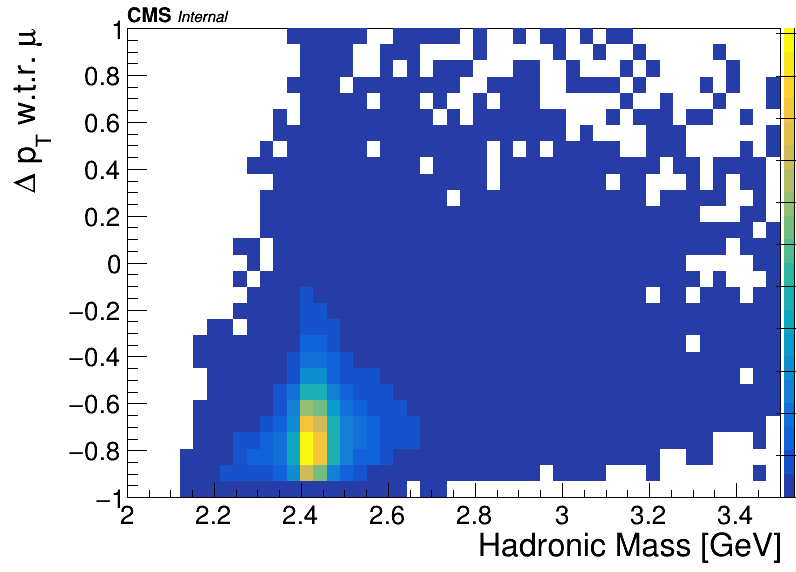

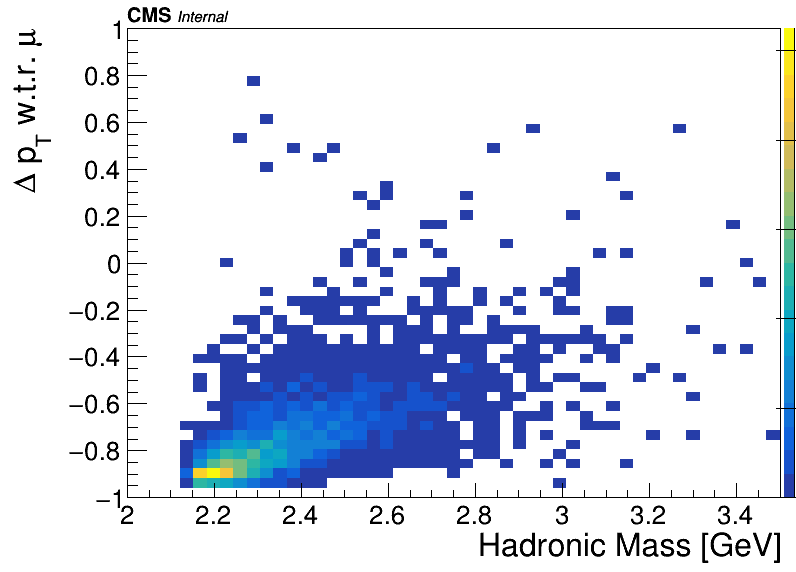

In [21]:
dRDstPi = (df['DstPip']['tkPt_0'][selDstPi] - df['DstPip']['mu_pt'][selDstPi])/df['DstPip']['mu_pt'][selDstPi]
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #mu', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')

dRMu = (df['mu']['tkPt_0'][selMu] - df['mu']['mu_pt'][selMu])/df['mu']['mu_pt'][selMu]
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 50)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #mu', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')

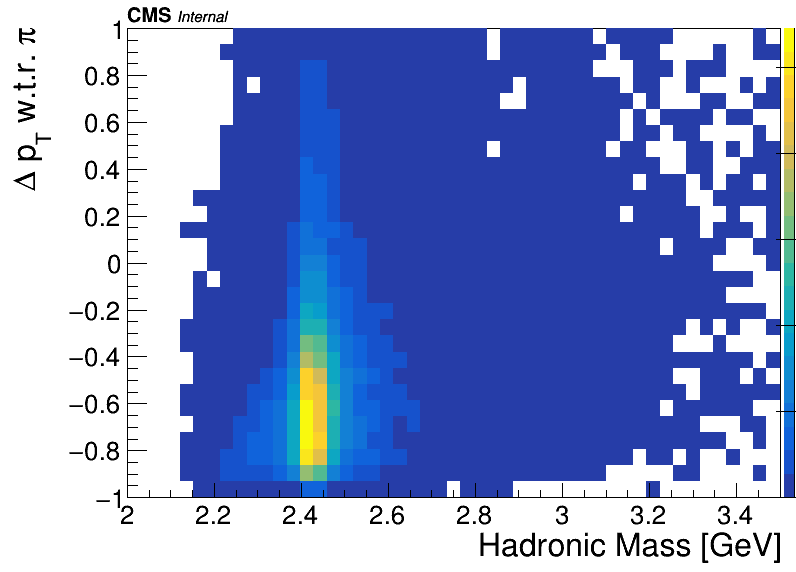

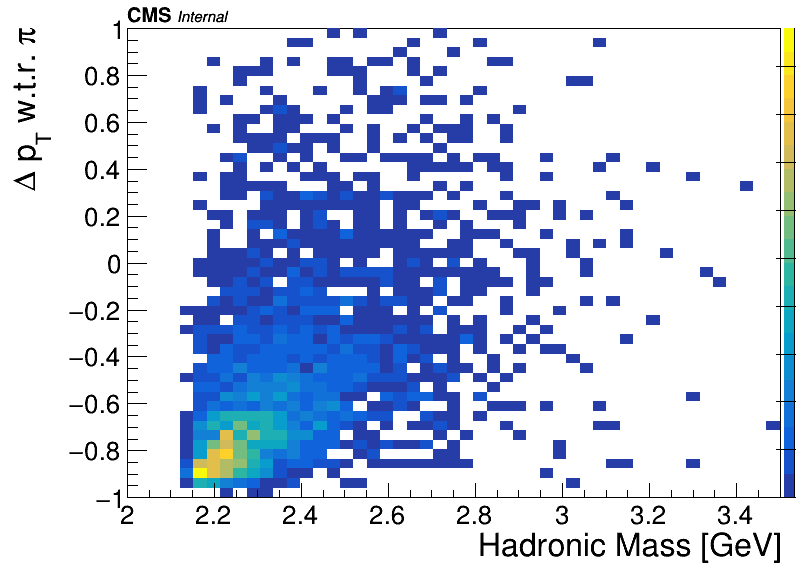

In [22]:
dRDstPi = (df['DstPip']['tkPt_0'][selDstPi] - df['DstPip']['pi_pt'][selDstPi])/df['DstPip']['pi_pt'][selDstPi]
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')

dRMu = (df['mu']['tkPt_0'][selMu] - df['mu']['pi_pt'][selMu])/df['mu']['pi_pt'][selMu]
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 50)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')

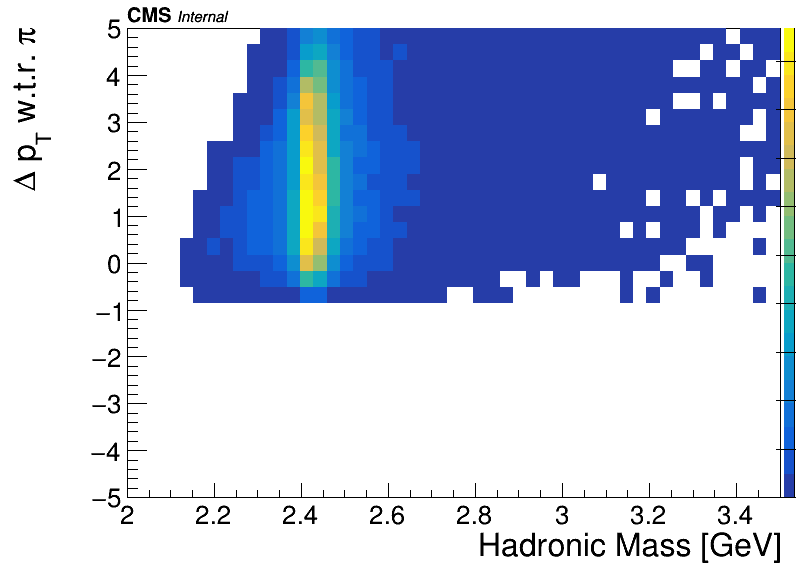

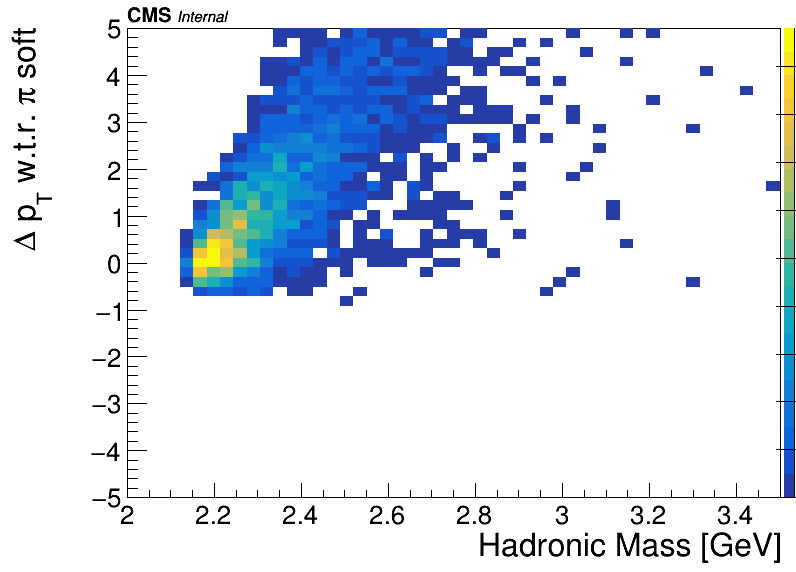

In [23]:
dRDstPi = (df['DstPip']['tkPt_0'][selDstPi] - df['DstPip']['pis_pt'][selDstPi])/df['DstPip']['pis_pt'][selDstPi]
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.linspace(-5, 5, 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')

dRMu = (df['mu']['tkPt_0'][selMu] - df['mu']['pis_pt'][selMu])/df['mu']['pis_pt'][selMu]
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.linspace(-5, 5, 50)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi soft', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')

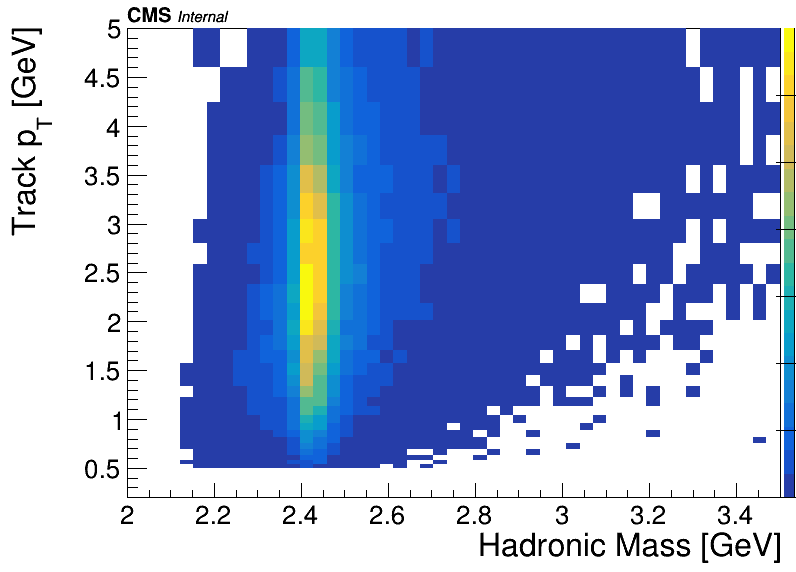

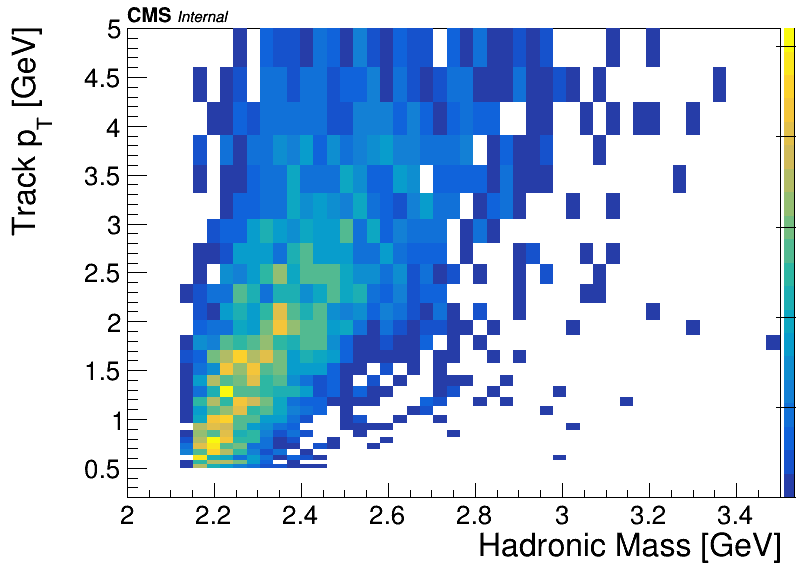

In [24]:
aux = np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], df['DstPip']['tkPt_0'][selDstPi]))
h = create_TH2D(aux, 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(np.log10(0.2), np.log10(5.0), 40)],
                axis_title=['Hadronic Mass [GeV]', 'Track p_{T} [GeV]', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')

aux = np.column_stack((df['mu']['tkMassHad_0'][selMu], df['mu']['tkPt_0'][selMu]))
h1 = create_TH2D(aux, 'mu',
                binning=h.binning,
                axis_title=['Hadronic Mass [GeV]', 'Track p_{T} [GeV]', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')

## PdgId Plots

In [25]:
pdgid2LatexName = {
0: 'N/A',
1: 'd',
-1: '\\bar{d}',
2: 'u',
-2: '\\bar{u}',
3: 's',
-3: '\\bar{s}',
4: 'c',
-4: '\\bar{c}',
5: 'b',
-5: '\\bar{b}',
11: 'e^{-}',
-11: 'e^{-}',
13: '\mu^{-}',
-13: '\mu^{+}',
15: '\\tau^{-}',
-15: '\\tau^{+}',
21: 'g',
22: '\gamma',  
111: '\pi_{0}',
113: '\\rho_{0}',
-113: '\\bar{\\rho}_{0}',
211: '\pi^{+}',
-211: '\pi^{-}',
213: '\\rho^{+}',
-213: '\\rho^{-}',
221: '\eta',
-221: '\\bar{eta}',
223: '\omega',
-223: '\\bar{omega}',
313: 'K^{*}_{0}',
-313: '\\bar{K}^{*}_{0}',
315: 'K_{2}^{*0}',
-315: '\\bar{K}_{2}^{*0}',
321: 'K^{+}',
-321: 'K^{-}',
323: 'K^{*+}',
-323: 'K^{*-}',
331: '\eta^{\prime}',
-331: '\\bar{eta}^{\prime}',
333: '\phi',
-333: '\\bar{phi}',
411: 'D^{+}',
-411: 'D^{-}',
413: 'D^{*+}',
-413: 'D^{*-}',
415: 'D_{2}^{*+}',
-415: 'D_{2}^{*-}',
421: 'D_{0}',
-421: '\\bar{D}_{0}',
423: 'D_{0}^{*}',
-423: '\\bar{D}_{0}^{*}',
425: 'D_{2}^{*0}',
-425: '\\bar{D}_{2}^{*0}',
431: 'D_{s}^{+}',
-431: 'D_{s}^{-}',
511: 'B_{0}',
-511: '\\bar{B}_{0}',
513: 'B_{0}^{*}',
-513: '\\bar{B}_{0}^{*}',
521: 'B^{+}',
-521: 'B^{-}',
523: 'B^{*+}',
-523: 'B^{*-}',
541: 'B_{c}^{+}',
-541: 'B_{c}^{-}',
543: 'B_{c}^{*+}',
-543: 'B_{c}^{*-}',
2212: 'p',
-2212: '\\bar{p}',
3112: '\Sigma^{-}',
-3112: '\Sigma^{+}',
3312: '\Xi^{-}',
-3312: '\Xi^{+}',
4122: '\Lambda_{c}^{+}',
-4122: '\Lambda_{c}^{-}',
4222: '\Lambda_{c}^{++}',
-4222: '\Lambda_{c}^{--}',
4224: '\Lambda_{c}^{*++}',
-4224: '\Lambda_{c}^{*--}',
10313: 'K_{1}^{0}',
-10313: '\\bar{K}_{1}^{0}',
10423: 'D_{1}^{0}',
-10423: '\\bar{D}_{1}^{0}',
20213: 'a_{1}^{+}',
-20213: 'a_{1}^{-}',
20423: 'D_{1}^{*}',
-20423: '\\bar{D}_{1}^{*0}'
}
# pdgid2LatexName

In [26]:
def plotPdgId(dname, varPdgId, sel=None, logy=False, size=(8,6), 
              threshold=1e-4, ylim=None, ylabel='Events fraction',
              verbose=False
             ):
    if sel is None:
        sel = np.ones_like(df[dname][varPdgId]).astype(np.bool)

    pdgId = {}
    auxList = list(df[dname][varPdgId][sel])
    nTot = 0
    for n in set(auxList):
        pdgId[n] = auxList.count(n)
        nTot += pdgId[n]
    print pdgId
    
    for k in pdgId.keys():
        pdgId[k] = pdgId[k]/float(nTot)
        if pdgId[k] < threshold:
            pdgId.pop(k)
            if verbose: print k, 'removed'

    weights = []
    sortedPdgId = np.sort(pdgId.keys())
    for k in sortedPdgId:
        weights.append(pdgId[k])


    n = len(weights)
    fig = plt.figure(figsize=size)
    plt.hist(np.arange(0, n), weights=np.array(weights), range=(-0.5, n-0.5), bins=n);
    plt.xticks(np.arange(0, n), [r'$'+pdgid2LatexName[x]+'$' for x in sortedPdgId])
    plt.ylabel(ylabel)
    if ylim is None:
        plt.ylim(threshold, 1)
    else:
        plt.ylim(ylim[0], ylim[1])
    if logy: plt.yscale('log')
    return fig

In [27]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.sans-serif': ['Verdana', 'Arial']})

### Study plots

{321.0: 41, 2212.0: 6, -211.0: 183, 211.0: 54113, -321.0: 40, -2212.0: 18, -13.0: 8}


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/1.5.2-gnimlf2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


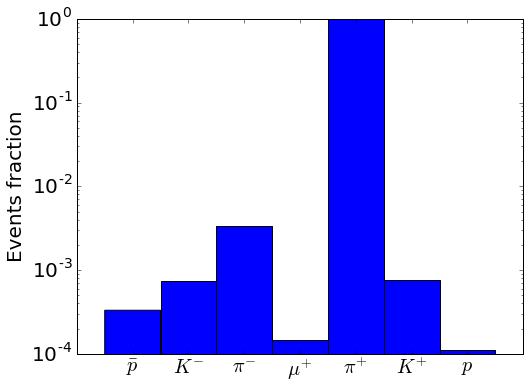

In [28]:
sel = np.logical_and(df['DstPip']['N_goodAddTks'] == 1, df['DstPip']['MC_tkFlag_0'] == 1)
plotPdgId('DstPip', 'MC_tkPdgId_0', sel=sel, logy=True);

{1.0: 15, 2.0: 14, 3.0: 11, 2212.0: 292, 421.0: 2, -10423.0: 24870, -425.0: 8201, 333.0: 3, -5.0: 13, 113.0: 1, 521.0: 8, -20423.0: 20954, -421.0: 25}


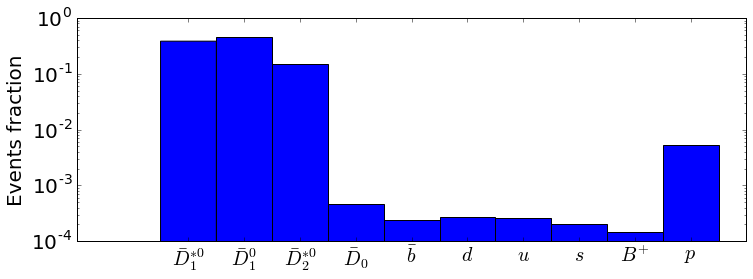

In [29]:
sel = np.logical_and(df['DstPip']['N_goodAddTks'] == 1, df['DstPip']['MC_tkFlag_0'] == 1)
fig = plotPdgId('DstPip', 'MC_tkMotherPdgId_0', sel=sel, size=(12,4), logy=True)

{321.0: 277, 2212.0: 122, 3112.0: 1, 11.0: 2, -211.0: 1933, 13.0: 3, -3312.0: 1, 211.0: 2840, -11.0: 6, -3112.0: 12, -321.0: 378, -2212.0: 162, -13.0: 5}


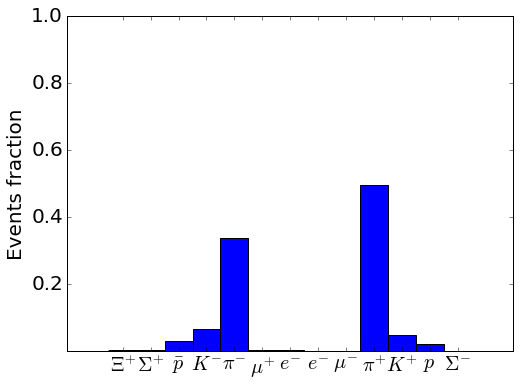

In [30]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['MC_tkFlag_0'] == 1)
plotPdgId('mu', 'MC_tkPdgId_0', sel=sel);

{1.0: 153, 2.0: 172, 3.0: 105, 4.0: 19, 5.0: 144, -511.0: 1, 4122.0: 1, 411.0: 7, 413.0: 1, 2212.0: 4843, 421.0: 9, 541.0: 2, 313.0: 3, 323.0: 2, -313.0: 3, -10423.0: 1, 333.0: 19, -431.0: 1, 213.0: 3, -20423.0: 2, -421.0: 15, 221.0: 2, 223.0: 1, -413.0: 19, -411.0: 4, -4122.0: 1, 113.0: 2, -521.0: 1, -5.0: 201, -4.0: 5}


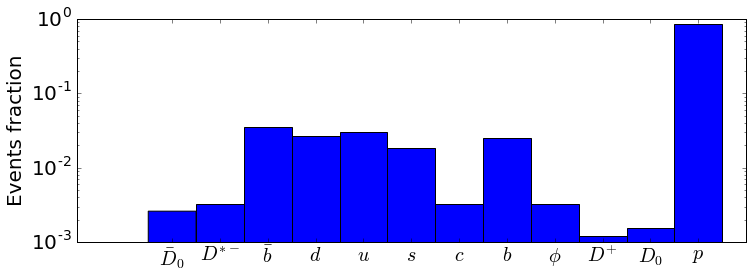

In [31]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['MC_tkFlag_0'] == 1)
fig = plotPdgId('mu', 'MC_tkMotherPdgId_0', sel=sel, size=(12,4), threshold=1e-3, logy=True)

{0.0: 4843, 1.0: 7, 2.0: 23, 3.0: 17, 4.0: 22, 5.0: 143, 521.0: 4, 21.0: 3, 411.0: 1, 541.0: 2, 543.0: 1, 2212.0: 361, 421.0: 3, 423.0: 2, 413.0: 6, 10313.0: 1, 331.0: 1, 333.0: 1, -431.0: 1, -513.0: 1, -423.0: 3, -421.0: 3, -413.0: 8, -1.0: 1, 20213.0: 1, -5.0: 258, -4.0: 5, 4222.0: 1, 511.0: 19}


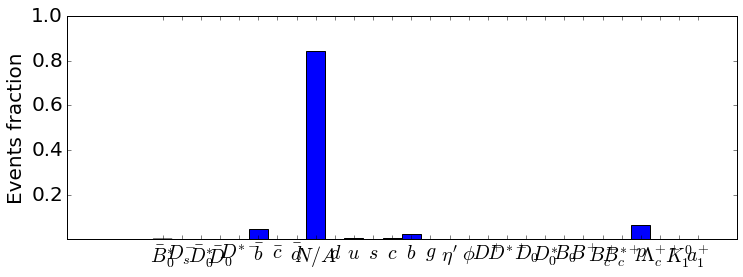

In [32]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['MC_tkFlag_0'] == 1)
fig = plotPdgId('mu', 'MC_tkMotherMotherPdgId_0', sel=sel, size=(12,4))

{1.0: 27, 2.0: 30, -541.0: 1, 2212.0: 736, 421.0: 1, -4122.0: 1, -421.0: 4, 333.0: 5, 113.0: 1, 3.0: 16, 4.0: 5, -5.0: 37, -4.0: 1, 5.0: 6}


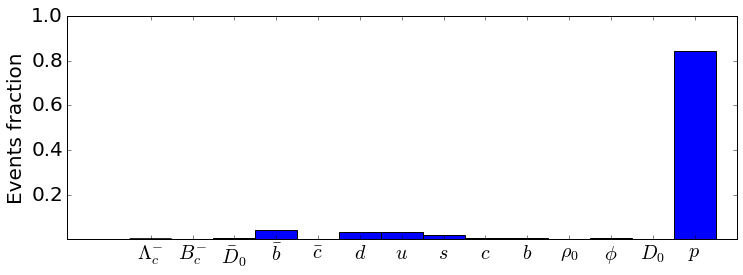

In [33]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 2, df['mu']['MC_tkFlag_0'] == 1)
fig = plotPdgId('mu', 'MC_tkMotherPdgId_0', sel=sel, size=(12,4))

{1.0: 10, 2.0: 10, 3.0: 10, 2212.0: 433, -411.0: 1, -511.0: 1, -10423.0: 1, 333.0: 3, -413.0: 2, 4.0: 4, -5.0: 17, 5.0: 3, 413.0: 2, 421.0: 1}


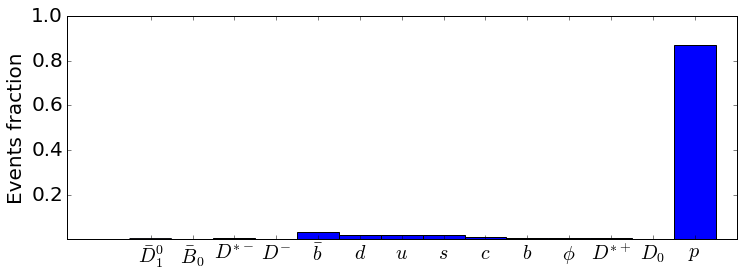

In [34]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 2, df['mu']['MC_tkFlag_1'] == 1)
fig = plotPdgId('mu', 'MC_tkMotherPdgId_1', sel=sel, size=(12,4))

{0.0: 736, 1.0: 3, 2.0: 2, 3.0: 3, 2212.0: 57, 5.0: 6, -543.0: 1, 333.0: 1, -431.0: 1, -413.0: 2, 21.0: 1, -423.0: 2, -5.0: 49, 411.0: 1, 4.0: 6}


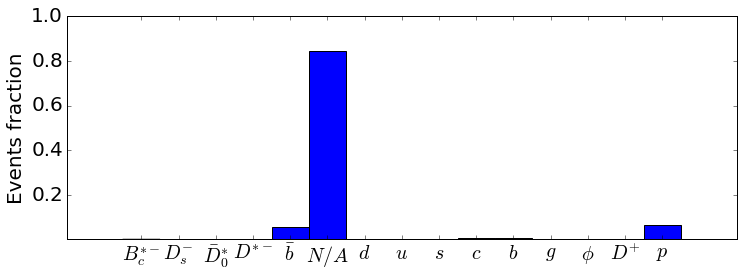

In [35]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 2, df['mu']['MC_tkFlag_0'] == 1)
fig = plotPdgId('mu', 'MC_tkMotherMotherPdgId_0', sel=sel, size=(12,4))

{1.0: 16, 2.0: 15, 3.0: 15, 2212.0: 231, -5.0: 16, -521.0: 1, 4.0: 3, -421.0: 1}


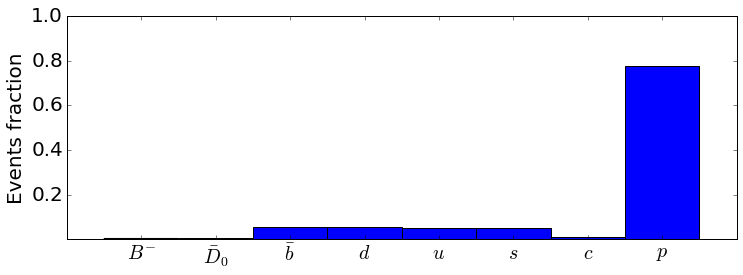

In [36]:
sel = np.logical_and(df['DstPip']['N_goodAddTks'] == 2, df['DstPip']['tkCharge_0']+df['DstPip']['tkCharge_1'] == 0)
sel = np.logical_and(sel, df['DstPip']['tkCharge_1'] < 0)
sel = np.logical_and(sel, df['DstPip']['MC_tkFlag_1'] == 1)
fig = plotPdgId('DstPip', 'MC_tkMotherPdgId_1', sel=sel, size=(12,4))

In [37]:
# sel = np.logical_and(df['Hc']['N_goodAddTks'] == 2, df['Hc']['tkCharge_0']+df['Hc']['tkCharge_1'] == 0)
# sel = np.logical_and(sel, df['Hc']['MC_tkFlag_1'] == 1)
# fig = plotPdgId('Hc', 'MC_tkMotherPdgId_1', sel=sel, size=(12,4))

### AN plots

{1.0: 96, 2.0: 124, 3.0: 71, 4.0: 14, 5.0: 51, 4122.0: 1, 411.0: 6, 413.0: 1, 2212.0: 2737, 421.0: 3, 541.0: 2, 313.0: 1, 323.0: 2, -313.0: 1, -10423.0: 1, 333.0: 11, 213.0: 3, -20423.0: 2, -421.0: 10, 221.0: 1, -411.0: 1, -5.0: 121, -4.0: 3}
{1.0: 57, 2.0: 48, 3.0: 34, 4.0: 5, 5.0: 93, -511.0: 1, 411.0: 1, 2212.0: 2106, 421.0: 6, 313.0: 2, -313.0: 2, 333.0: 8, -431.0: 1, -421.0: 5, 221.0: 1, 223.0: 1, -413.0: 19, -411.0: 3, -4122.0: 1, 113.0: 2, -521.0: 1, -5.0: 80, -4.0: 2}
{1.0: 3, 2.0: 4, 3.0: 1, 2212.0: 95, -10423.0: 24870, -421.0: 25, -425.0: 8201, 333.0: 2, 521.0: 8, -20423.0: 20954, -5.0: 5}
{1.0: 12, 2.0: 10, 3.0: 10, 2212.0: 197, 421.0: 2, 333.0: 1, 113.0: 1, -5.0: 8}


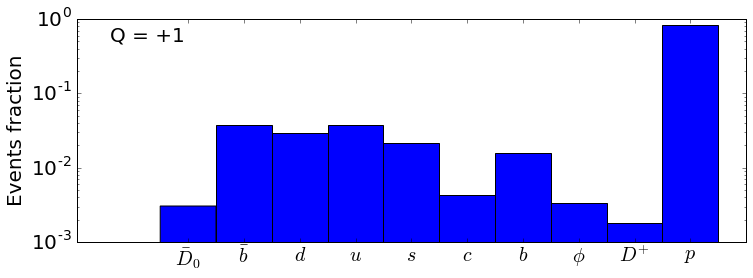

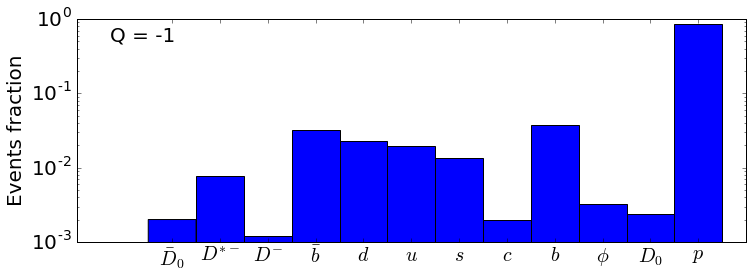

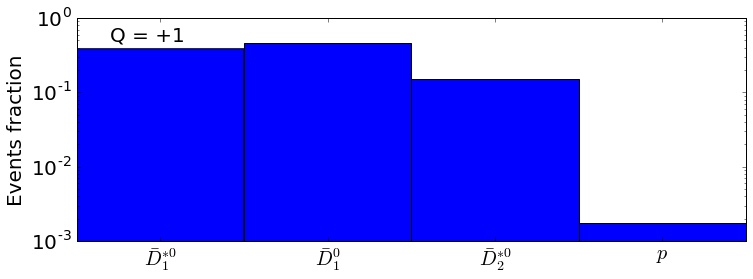

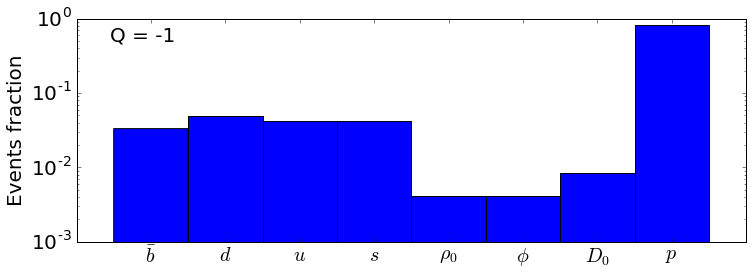

In [38]:
for dn in ['mu', 'DstPip']:
    d = df[dn]
    sel = np.logical_and(d['N_goodAddTks'] == 1, d['MC_tkFlag_0'] == 1)
    fig = plotPdgId(dn, 'MC_tkMotherPdgId_0', sel=np.logical_and(sel, d['tkCharge_0'] > 0),
                    size=(12,4), threshold=1e-3, logy=True)
    xmin, xmax = plt.xlim()
    plt.text(xmin + 0.05*(xmax - xmin) , 0.5, 'Q = +1')
    
    fig = plotPdgId(dn, 'MC_tkMotherPdgId_0', sel=np.logical_and(sel, d['tkCharge_0'] < 0),
                    size=(12,4), threshold=1e-3, logy=True)
    xmin, xmax = plt.xlim()
    plt.text(xmin + 0.05*(xmax - xmin) , 0.5, 'Q = -1')

## All data

In [39]:
date = '200515'
RDloc = '../data/cmsRD/skimmed/B2DstMu_{}_{}_trkCtrl_corr.root'.format(date, cat.name)
df['data'] = pd.DataFrame(rtnp.root2array(RDloc))
datasets_loc = glob('../data/cmsRD/ParkingBPH*/*2018*B2DstMu_{}*'.format(date))
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part1_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.39 fb^-1


## MC comparison

In [40]:
from pileup_utilities import pileupReweighter
puRew = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_trkCtrl_corr.root'.format(cat.name), cat)

In [41]:
baseSelMC = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['tkCharge_0'] == -1)
baseSelRD = np.logical_and(df['data']['N_goodAddTks'] == 1, df['data']['tkCharge_0'] == -1)

In [42]:
def plotComp(var, binning, xtitle, logy=False):
    leg = rt.TLegend(0.6, 0.6, 0.95, 0.9)
    leg.SetBorderSize(0)
    leg.SetTextFont(42)

    hlist = []

    h = create_TH1D(df['data'][var][baseSelRD], binning=binning, 
                    opt='underflow+overflow',
                    axis_title=[xtitle, 'Normalized entries'], scale_histo='norm')
    leg.AddEntry(h, 'data', 'lep')
    hlist.append(h)

    puWeights = puRew.getPileupWeights(df['mu']['N_vtx'])

    sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == -1)
    h = create_TH1D(df['mu'][var][sel], binning=h.binning,
                    weights=puWeights[sel],
                    opt='underflow+overflow',
                    scale_histo='norm', color=0)
    leg.AddEntry(h, 'B #rightarrow D*#mu#nu (PU only)', 'lep')
    hlist.append(h)

    sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == 1)
    h = create_TH1D(df['mu'][var][sel], binning=h.binning,
                    weights=puWeights[sel],
                    opt='underflow+overflow',
                    scale_histo='norm', color=1)
    leg.AddEntry(h, 'B #rightarrow D*#mu#nu (PV only)', 'lep')
    hlist.append(h)

    h = create_TH1D(df['mu'][var][baseSelMC],
                    weights=puWeights[baseSelMC],
                    opt='underflow+overflow',
                    binning=h.binning, scale_histo='norm', color=2)
    leg.AddEntry(h, 'B #rightarrow D*#mu#nu', 'lep')
    hlist.append(h)

    m = SetMaxToMaxHist(hlist)
    c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
    if logy:
        hlist[0].GetYaxis().SetRangeUser(logy, m)
        c.SetLogy()
    leg.Draw()
    c.dnd = [leg, hlist]
    return c

<ROOT.TCanvas object ("c") at 0xcbb1690>

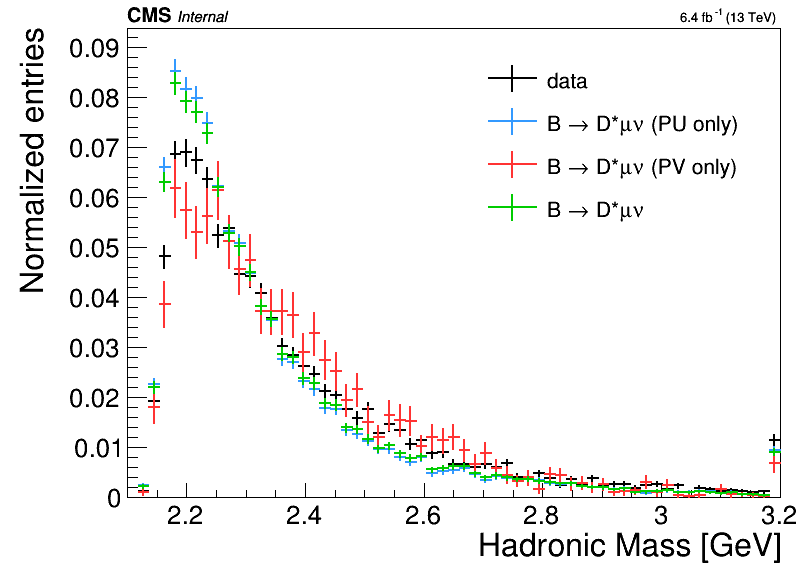

In [43]:
plotComp('tkMassHad_0', [61, 2.1, 3.2], 'Hadronic Mass [GeV]')

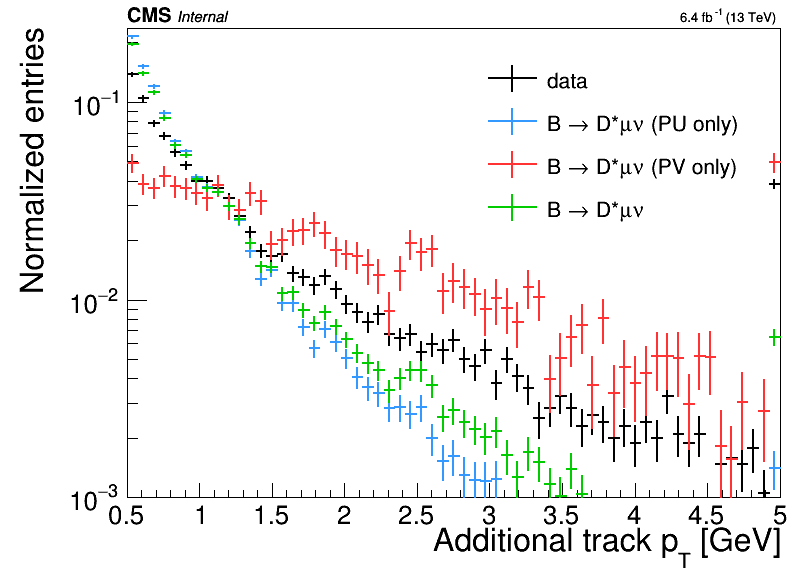

In [44]:
c = plotComp('tkPt_0', [61, 0.5, 5.0], 'Additional track p_{T} [GeV]', logy=1e-3)

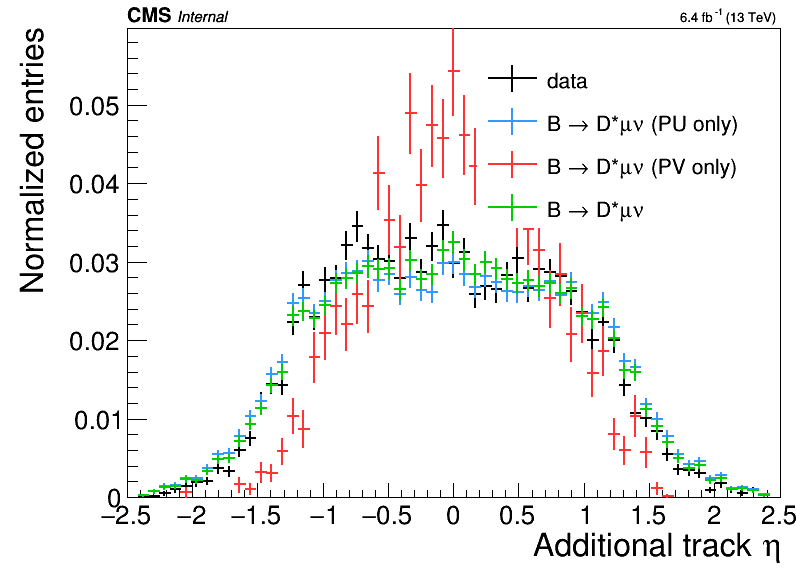

In [45]:
c = plotComp('tkEta_0', [61, -2.5, 2.5], 'Additional track #eta')

fPV (pre-fit): 0.101
chi2: 130.4/43 0.000
fPV = 0.394 +/- 0.008 [2.0%]
PV weight: 3.9 +/- 0.1


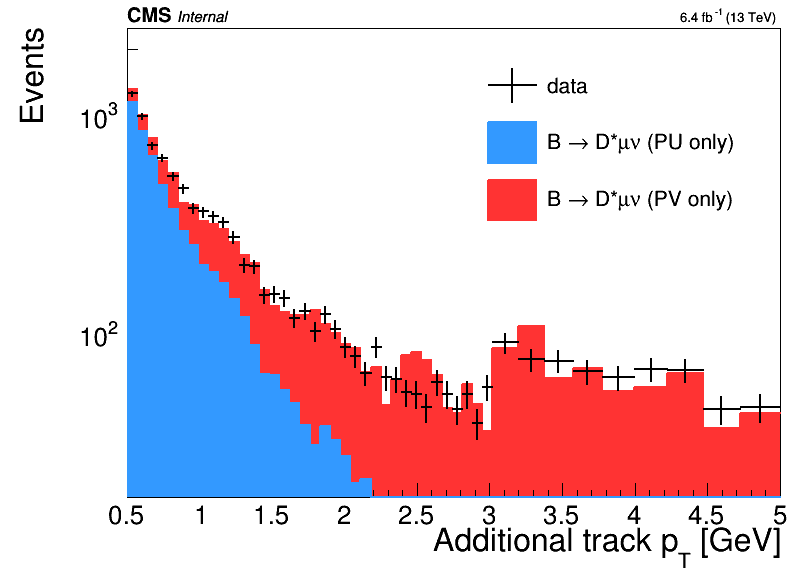

In [46]:
var = 'tkPt_0'

binning = np.logspace(np.log10(0.5), np.log10(5.0), 40)
binning = [61, 0.3, 5.0]
binning = array('d', list(np.arange(0.5, 3.02, 0.07)) + list(np.logspace(np.log10(3.02), np.log10(5.0), 10)))
hRD = create_TH1D(df['data'][var][baseSelRD], binning=binning)
hRD.Sumw2()

puWeights = puRew.getPileupWeights(df['mu']['N_vtx'])

sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == -1)
hMC_PU = create_TH1D(df['mu'][var][sel], binning=hRD.binning, color=0, weights=puWeights[sel])


sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == 1)
hMC_PV = create_TH1D(df['mu'][var][sel], binning=hRD.binning, color=1, weights=puWeights[sel],
                     axis_title=['Additional track p_{T} [GeV]', 'Events']
                    )

r_pre = hMC_PV.Integral()/(hMC_PV.Integral() + hMC_PU.Integral())
print 'fPV (pre-fit): {:.3f}'.format(r_pre)
hMC_PU.Scale(1./hMC_PU.Integral())
hMC_PV.Scale(1./hMC_PV.Integral())

pt = rt.RooRealVar('pt', 'p_{T}', 0.5, 5.0, 'GeV')

data = rt.RooDataHist('Data', 'Data', rt.RooArgList(pt), hRD)
N_data = hRD.Integral()

dh_PU = rt.RooDataHist('dh_PU', 'hPU', rt.RooArgList(pt), hMC_PU)
pdf_PU = rt.RooHistPdf('pdf_PU', 'pdf_PU', rt.RooArgSet(pt), dh_PU)
n_PU = rt.RooRealVar('n_PU', 'N_{PU}', N_data*0.5, 0, N_data)

dh_PV = rt.RooDataHist('dh_PV', 'hPV', rt.RooArgList(pt), hMC_PV)
pdf_PV = rt.RooHistPdf('pdf_PV', 'pdf_PV', rt.RooArgSet(pt), dh_PV)
n_PV = rt.RooRealVar('n_PV', 'N_{PV}', N_data*0.5, 0, N_data)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_PU, pdf_PV), rt.RooArgList(n_PU, n_PV))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = hRD.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

r = n_PV.getVal()/(n_PV.getVal() + n_PU.getVal())

dr = np.hypot(n_PV.getVal()*n_PU.getError(), n_PU.getVal()*n_PV.getError())/((n_PV.getVal() + n_PU.getVal())**2)
print 'fPV = {:.3f} +/- {:.3f} [{:.1f}%]'.format(r, dr, 100*dr/r)
print 'PV weight: {:.1f} +/- {:.1f}'.format(r/r_pre, dr/r_pre)

hMC_PU.Scale(n_PU.getVal())
hMC_PV.Scale(n_PV.getVal())
hMC_PV.Add(hMC_PU)
hMC_PU.Sumw2(0)
hMC_PU.SetFillStyle(1)
hMC_PV.Sumw2(0)
hMC_PV.SetFillStyle(1)
c = drawOnCMSCanvas(CMS_lumi, [hMC_PV, hMC_PU, hRD], 'same')

leg = rt.TLegend(0.6, 0.6, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)
leg.AddEntry(hRD, 'data', 'lep')
leg.AddEntry(hMC_PU, 'B #rightarrow D*#mu#nu (PU only)', 'f')
leg.AddEntry(hMC_PV, 'B #rightarrow D*#mu#nu (PV only)', 'f')
leg.Draw()
c.SetLogy()